<!-- ![RWTH Logo](https://www.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaaagazb) -->
![iAMB Logo](https://www.iamb.rwth-aachen.de/global/show_picture.asp?id=aaaaaaaaaanwtny)
# Metabolic Flux Analysis

* Execute a single cell: <span class="fa-play fa"></span>
* Execute all cells: Menu: Run <span class="fa-chevron-right fa"></span> Run All Cells
* To reboot kernel: <span class="fa-refresh fa"></span>

Find more in the reference (menu: Help <span class="fa-chevron-right fa"></span> Jupyter Reference).

This workflow guides through the analysis of a 13C isotope labeling experiment to calculate reaction fluxes.  

Additional resources:
 - [MFApy publication Matsuda et al. (2021)](https://doi.org/10.1016/j.mec.2021.e00177)
 - [MFApy documentation](https://fumiomatsuda.github.io/mfapy-document/mfapy.html)
 - [MFApy Github](https://github.com/fumiomatsuda/mfapy)
 

### Libraries
Loading required libraries for analysis.

 - Input:  None
 - Output: Text: `Libraries loaded.`

In [6]:
import os, glob, csv, sys, time, subprocess, pkg_resources, copy, socket
import pandas as pd
import numpy as np
from datetime import date
from scipy import stats
import ipywidgets as widgets

import matplotlib.pyplot as plt
%matplotlib inline

myhost = socket.gethostname()
if myhost not in ['Family','IAMBPC145']:
    print('update iambcodes')
    !pip install iambcodes==0.0.13
from iambcodes.rates import *

# https://stackoverflow.com/questions/44210656/how-to-check-if-a-module-is-installed-in-python-and-if-not-install-it-within-t
required = {'mfapy'}
installed = {pkg.key for pkg in pkg_resources.working_set}
missing = required - installed

if missing:
    print('Download and install of mfapy.')
    !pip install -r requirements.txt
import mfapy
    
print('Libraries loaded.')

Libraries loaded.


In [7]:
# Load existing configuration file, or leave the list empty
ConfFile = '' #/home/ulf/Documents/2111_iambjudas/RatesYields/myconf.txt
if ConfFile:
    Par_Dict = ReadConf(ConfFile)
# General Working Directory
# For automatic reading of directory, e.g. in cloud use:
# Target_Dir = os.path.join(os.getcwd(), 'MFA')
Target_Dir = 'MFA/Ppan' # os.path.join(os.getcwd(), 'MFA') if not ConfFile else Par_Dict['Target_Dir']
ModelFile = 'Tst_small.txt' # 'Ecoli_model-short.txt' if not ConfFile else Par_Dict['ModelFile']
ModelFileAddress = os.path.join(Target_Dir, ModelFile)
StatusFile = 'Tst_status.csv' # 'Ecoli_status-short.csv' if not ConfFile else Par_Dict['StatusFile']
StatusFileAddress = os.path.join(Target_Dir, StatusFile)

# # Output Files
# # All files are attached with the current date
Today = date.today().strftime('%y%m%d')
# Choose image file type, e.g. svg, png, pdf, eps
ImageType = 'png' if not ConfFile else Par_Dict['ImageType']
print('Workspace initiated.')

Workspace initiated.


In [80]:
reactions, reversible, metabolites, target_fragments = mfapy.mfapyio.load_metabolic_model(ModelFileAddress, format = "text", mode = "normal")
model = mfapy.metabolicmodel.MetabolicModel(reactions, reversible, metabolites, target_fragments, mode = "normal")
#
# Addtion of constrains
#
state_dic = model.load_states(StatusFileAddress, format = 'csv')
model.set_constraints_from_state_dict(state_dic)
#
# Label carbon source
#
cs = model.generate_carbon_source_template()
cs.set_each_isotopomer('SubsGlc',{'#111111':0.5,'#100000':0.5}, correction='no')
cs.set_each_isotopomer('SubsCO2',{'#1':0,'#0':1}, correction='no')

True

In [81]:
independent_vector, lb, ub, independent_list = model.get_independents(state_dic)
check, flux_vector, reaction_name = model.check_independents(independent_vector)
print(check)
print(flux_vector)
print(reaction_name)

False
[ 1.00000000e+01  5.00000000e+00  9.77740000e+00  9.64780000e+00
  1.86998000e+01 -1.70200000e+00  2.02461000e+01  0.00000000e+00
  5.00000000e+00  2.44810000e+00  1.51520000e+01  2.89803000e+01
  2.86566000e+01  1.48283000e+01  1.00000000e+00  0.00000000e+00
 -1.38283000e+01  1.61100000e-01 -1.08300000e-01  0.00000000e+00
 -5.28255070e-33  0.00000000e+00  0.00000000e+00  0.00000000e+00
 -1.08300000e-01  0.00000000e+00  1.46400000e-01  6.95400000e-01
  3.23700000e-01  6.15000000e-02  3.00000000e-01  5.00000000e+01
  3.00000000e-01  5.58000000e-01  1.00000000e+02  1.00000000e+01
  1.00000000e+02  1.00000000e+02  0.00000000e+00  1.00000000e+02
  1.00000000e+02  0.00000000e+00  1.00000000e+02  0.00000000e+00
  0.00000000e+00  1.00000000e+02  1.00000000e+02  1.00000000e+02
  1.00000000e+02  1.00000000e+02  1.00000000e+02  0.00000000e+00
  0.00000000e+00  1.00000000e+02  0.00000000e+00  1.00000000e+00
 -1.08300000e-01 -1.54074396e-33 -1.08300000e-01  0.00000000e+00]
['PTS', 'CIN', 'PG

In [82]:
#
# Generate MDVs
#
SimMDV = True
SaveMDV = True
if SimMDV:
    mdv = model.generate_mdv(state_dic, cs)
    mdv.add_gaussian_noise(0.01)
    mdv.set_std(0.01, method = 'absolute')
else:
    mdv = model.load_mdv_data(os.path.join(Target_Dir, "Ecoli_Ulf_TstMDV.csv"), format='csv')
#
# Addition of labeling experiment 1
#
model.clear_experiment()
model.set_experiment('ex1', mdv, cs)
model.update()    
state, state_dic2 = model.generate_initial_states(100,10, method='parallel')

#
# reading default flux vector
#
ivec, _, _, ilist = model.get_independents(state_dic)
check, fluxvec, rname = model.check_independents(ivec)

exp_dic = copy.deepcopy(state_dic2[0])
# for the experiment setting all reactions to 100, only the fixed reaction is used.
[exp_dic['reaction'][myRct].update({'value':100}) for myRct in exp_dic['reaction']]
# setting the fitted reaction to the real value
[exp_dic['reaction'][myRct].update({'value':state_dic2[0]['reaction'][myRct]['value']}) for myRct in exp_dic['reaction'] if exp_dic['reaction'][myRct]['type']=='fitting']
# setting the fixed reaction to the real value
[exp_dic['reaction'][myRct].update({'value':state_dic2[0]['reaction'][myRct]['value']}) for myRct in exp_dic['reaction'] if exp_dic['reaction'][myRct]['type']=='fixed']

model.show_results([('ref',state_dic2[0]), ('init',exp_dic)])
if SaveMDV:
    mdv.save(os.path.join(Target_Dir, 'Ecoli_Ulf_TstMDV.csv'), format = "csv")
    model.save_states(state_dic2[0], os.path.join(Target_Dir, 'Ecoli_Ulf_TstRefState.csv'), format = "csv")
    model.save_states(exp_dic, os.path.join(Target_Dir, 'Ecoli_Ulf_TstExpState.csv'), format = "csv")


Id             Reaction                 External i     ref    init
RSS                                                1592.447434380.47
Thres                                                21.03   21.03
p_value                                               0.00    0.00
Id             Reaction                 External i     ref    init Type     Value Stdev    lb    ub Atom_mapping             
PTS            SubsGlc-->G6P            (kegg:R028    10.0    10.0 fixed     10.0   0.1   0.0 300.0 ABCDEF-->ABCDEF          
CIN            SubsCO2-->CO2in          (no)           5.0     5.0 fixed      5.0   1.0   0.0 300.0 A-->A                    
PGI            G6P-->F6P                (kegg:R007     9.1   100.0 free       5.0   1.0   0.0 300.0 ABCDEF-->ABCDEF          
FBA            F6P-->{2}GAP             (kegg:R010     9.4   100.0 free       6.0   1.0   0.0 300.0 ABCDEF-->CBA+DEF         
ENO            GAP-->PEP                (kegg:R010    18.5   100.0 free       5.0   1.0   0.0 300.0 

In [92]:
#
# Loading fluxes for fitting from state file
#
LoadFluxFit = True
if LoadFluxFit:
    flux_dic = model.load_states(os.path.join(Target_Dir, 'Ecoli_Ulf_TstExpState.csv'), format = 'csv')
    model.set_constraints_from_state_dict(flux_dic)
#     state, flux_fit = model.generate_initial_states(100,10, method='parallel', template=flux_dic)
#     model.set_constraints_from_state_dict(flux_fit[0])

print('Model prepared.')
# #
# # correction of flux rates
# #
# state, flux_init = model.generate_initial_states(100,10, method='parallel', template=state_dic)
# state_dic = flux_init[0]
# model.set_constraints_from_state_dict(state_dic)

# ivec, _, _, ilist = model.get_independents(state_dic)
# check, fluxvec, rname = model.check_independents(ivec)

Model prepared.


In [93]:
id_array, ratio_array, std_array, use_array, observed_fragments, data = mdv.generate_observed_mdv()
myCheck = id_array[0].split('_')[0]
FigNum = len(observed_fragments)
FractLab = dict()
# FigAxis = np.ceil(np.sqrt(24))
plt.figure(figsize=(30,25))
# fig, axs = plt.subplots(FigNum)
for indx, frag in enumerate(observed_fragments):
    fragMDV = mdv.get_fragment_mdv(frag)
    # calculation of fractional labeling, e.g. eq2 in 10.1016/j.copbio.2015.02.003
    FractLab[frag] = np.sum(fragMDV*np.arange(len(fragMDV)))/(len(fragMDV)-1)
    plt.subplot(5,5,indx+1)
    plt.bar(range(len(fragMDV)),fragMDV)
    plt.title(frag)
plt.show()
plt.bar(range(len(FractLab)), FractLab.values())
plt.xticks(range(len(FractLab)), FractLab.keys(), rotation=90)
plt.title('Fractional Labeling')
plt.show()

In [94]:
state, flux_initial = model.generate_initial_states(200, 8, method ="parallel")
state, RSS_bestfit, flux_opt1 = model.fitting_flux(method = "GN_CRS2_LM", flux = flux_initial)
state, RSS_bestfit, flux_opt2 = model.fitting_flux(method = "deep", flux = flux_opt1)
pvalue, rss_thres = model.goodness_of_fit(flux_opt2[0], alpha = 0.05)
#
# Target reactions to estimate 95% CI
#
target_reactions = [('reaction', "r1"),('reaction', "r17"),('reaction', "r26"),('reaction', "r27"),('reaction', "r40"),('reaction', "r41"),('reaction', "r42")]
ci_edge = model.generate_ci_template(targets = target_reactions)
#
# Grid search
#
#
# Configurations
#
model.set_configuration(callbacklevel = 0) #
model.set_configuration(iteration_max = 10000)
model.set_configuration(initial_search_repeats_in_grid_search = 5) # Number of repeat for finding initial flux in Grid search mode such as model.generate_initial_states(5, 1)
model.set_configuration(grid_search_iterations = 1) # Fitting interations at each grid.
# model.set_configuration(ncpus = 4) #Number of local CPUs for joblib
model.set_configuration(number_of_repeat = 3) #Iteration in self.fitting_flux(method = 'deep') [SLSQP => LN_PRAXIS] * n
ci = model.search_ci(ci_edge, flux_opt2[0], method = 'grid')

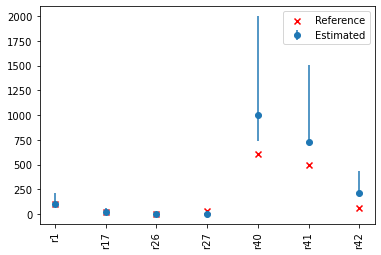

Id             Reaction                 External i     ref    init  fitted
RSS                                                4108.494897786.81 1458.61
Thres                                                95.08   95.08   95.08
p_value                                               0.00    0.00    0.00
Id             Reaction                 External i     ref    init  fitted Type     Value Stdev    lb    ub Atom_mapping             
r1             SubsGlc-->G6P            (kegg:R028   103.6   103.6   105.9 fitting  103.6   1.6   0.01000.0 ABCDEF-->ABCDEF          
r2             G6P-->F6P                (kegg:R007    73.4   100.0   102.8 free     100.0   1.0   0.01000.0 ABCDEF-->ABCDEF          
r4             F6P-->FBP                (kegg:R007    81.0   100.0    91.2 free     100.0   1.0   0.01000.0 ABCDEF-->ABCDEF          
r6             FBP-->DHAP+GAP           (kegg:R010   920.5   100.0   806.3 free     100.0   1.0   0.01000.0 ABCDEF-->CBA+DEF         
r7             DHAP+GAP-->FB

In [95]:
#
# Output of grid search results
#
# if LoadFluxFit:
#     flux_ref = model.load_states(os.path.join(Target_Dir, 'Ecoli_Ulf_TstRefState.csv'), format = 'csv')
#     RefVal = np.array([mydict['value'] for mydict in [flux_ref[myRct[0]][myRct[1]] for myRct in target_reactions]])
# else:
RefVal = np.array([mydict['value'] for mydict in [state_dic2[0][myRct[0]][myRct[1]] for myRct in target_reactions]])
FitVal = np.array([mydict['value'] for mydict in [flux_opt2[0][myRct[0]][myRct[1]] for myRct in target_reactions]])
lb = np.array([element['lower_boundary'] for element in list(map(ci['data'].get, target_reactions))])
ub = np.array([element['upper_boundary'] for element in list(map(ci['data'].get, target_reactions))])
ErrorAsym = np.array(list(zip(lb, ub))).T
TargetNames = [myRct[1] for myRct in target_reactions]
plt.scatter(range(len(RefVal)), RefVal, marker='x', c='r', label='Reference')
plt.errorbar(range(len(FitVal)), FitVal, yerr=ErrorAsym, fmt='o', label='Estimated')
plt.xticks(range(len(TargetNames)), TargetNames, rotation=90)
plt.legend()
plt.show()
results = [('ref',state_dic2[0]),('init',flux_dic),('fitted',flux_opt2[0])] #
print(model.show_results(results))